#  1. Data Preparing

In [2]:
import numpy as np
import math
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

import utils
import utils_cl

%matplotlib notebook
%load_ext autoreload

In [3]:
normal_df = pd.read_csv("dataset/normal_data_removed4months.csv")
fraud_df  = pd.read_csv("dataset/fraud_data_removed4months.csv")
normal_df.drop(columns = ['index'], inplace = True)
fraud_df.drop(columns = ['index'], inplace = True)

In [4]:
normal_df["IS_FRAUD"] = 0
fraud_df["IS_FRAUD"] = 1

In [5]:
df = pd.concat([normal_df, fraud_df], ignore_index=True, sort = False)
list_mdd = list(set(df['MA_DIEMDO']))
list_fraud_mdd = list(fraud_df['MA_DIEMDO'])
list_normal_mdd = list(normal_df['MA_DIEMDO'])

In [83]:
df.head(3)

,MA_DIEMDO,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,IS_FRAUD
0,PP05000508216001,2.667740,2.711795,2.442853,2.611166,4.418568,3.202143,4.329848,3.605783,2.610987,2.103955,2.009306,2.145708,2.662149,2.406113,3.454810,0
1,PP03000843440001,1.304481,1.565816,1.655026,1.799680,1.811263,1.825344,1.678522,1.742634,1.793468,1.688307,1.034212,1.176423,0.975054,0.818717,1.293632,0
2,PP07000604342001,1.170328,0.867527,1.099991,1.138343,1.322272,1.354671,1.382665,1.453378,1.371687,1.071658,1.634800,1.484191,1.029991,1.291284,1.329580,0


# 2. Clustering

In [1]:
# Scale Data
X = df.iloc[:, 1:-1].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

X_normalized = normalize(X_scaled, axis=1)
X_normalized = pd.DataFrame(X_normalized)


n_normal = len(list_normal_mdd)
X_normal = X_normalized.iloc[:n_normal, :]
X_fraud = X_normalized.iloc[n_normal:, :]

NameError: name 'df' is not defined

In [2]:
# Split Normal data into Train & Test set
X_normal_train = X_normal.sample(frac = 0.8, random_state = 0)
X_normal_test = X_normal.drop(X_normal_train.index)

NameError: name 'X_normal' is not defined

In [97]:
# Clustering
## Distance using : Euclidean or DTW

distance_used = utils_cl.distance_ED
#distance_used = utils_cl.distance_DTW

n_iters = 500
cluster_number = 3
Clustering_result, centroids = utils_cl.K_Mean(np.array(X_normal_train), n_iters, cluster_number, metric = 'euclidean')

average_radius = []
for i, cent in enumerate(centroids) :
    s = 0
    for _p in Clustering_result[i+1]:
        EDist_cluster_p2c = distance_used(cent, _p)
        s += EDist_cluster_p2c
    s = s / (len(Clustering_result[i+1]))
    average_radius.append(s)

<IPython.core.display.Javascript object>


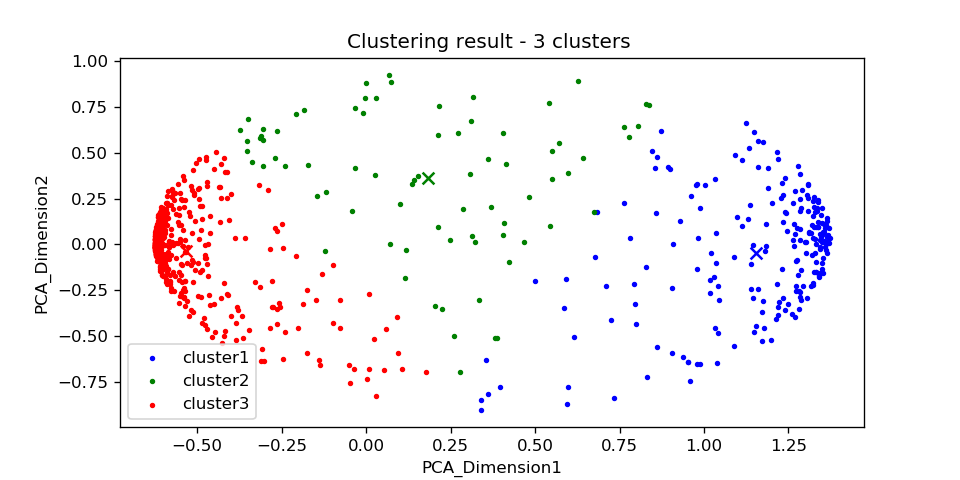

In [98]:
# Plot clustering result in PCA-2 Dimension
pca_plot = PCA(n_components=2)
principalComponents = pca_plot.fit(X_normal_train)

result_2D = {}
i = 0
centroid_2D = []
for _item in Clustering_result :
    result_2D[_item] = []
    for _point in Clustering_result[_item]:
        result_2D[_item].append(principalComponents.transform([_point])[0])
    centroid_2D.append(principalComponents.transform([centroids[i]])[0])
    i += 1

def centroid_plt2D(result, cluster_number, centroid):
    plt.figure(figsize = (8, 4), dpi = 120)
    if cluster_number > 7:
        colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), cluster_number, replace = True)
    else :
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    labels=['cluster' + str(i+1) for i in range(cluster_number)]
    for k in range(cluster_number):
        d1 = [result[k+1][i][0] for i in range(len(result[k+1]))]
        d2 = [result[k+1][i][1] for i in range(len(result[k+1]))]
        plt.scatter(d1, d2, c=colors[k], s=5, label=labels[k])
        plt.scatter(centroid[k][0], centroid[k][1], s=50, c=colors[k], marker = "x")
    plt.xlabel('PCA_Dimension1')
    plt.ylabel('PCA_Dimension2')
    plt.title("Clustering result - " + str(cluster_number) + " clusters ")
    plt.legend()
    plt.show()
centroid_plt2D(result_2D, cluster_number, centroid_2D)

<IPython.core.display.Javascript object>


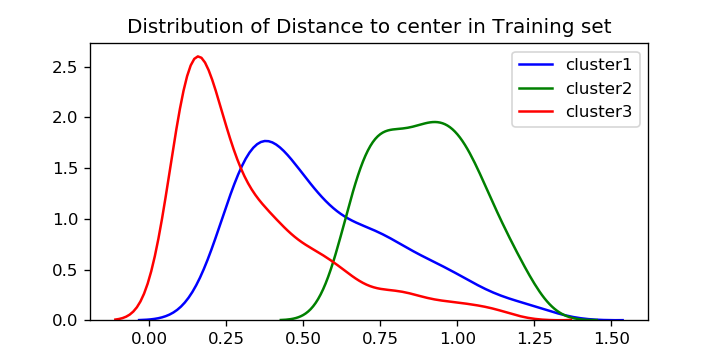

In [99]:
# Plot Distribution of each Cluster
dict_DC = {}
for i in range(cluster_number):
    list_distance_cluster_i = []
    for _p in Clustering_result[i+1]:
        list_distance_cluster_i.append(distance_used(centroids[i], _p))
    dict_DC[i+1] = list_distance_cluster_i
    
def distribution_plotting(cluster_number, is_print_individual = False):
    if cluster_number > 7:
        colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), cluster_number, replace = True)
    else :
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    if is_print_individual : 
        for i in range(cluster_number):
            plt.figure(figsize = (4, 2), dpi = 120)
            sns.distplot(dict_DC[i+1])
            plt.title("Distribution of Distance to Center"  + str(i+1))
        
    plt.figure(figsize = (6, 3), dpi = 120)
    for i in range(cluster_number):
        sns.kdeplot(dict_DC[i+1], label="cluster" + str(i+1), color = colors[i])
    plt.legend();
    plt.title("Distribution of Distance to center in Training set")
distribution_plotting(cluster_number, False)

# 3. Fraud Set prediction 

In [107]:
# Predicting
def test_mdd_fraud(test_mdd, thresh_hold_KM = 1.0):
    # ED_test2c : distance from test_mdd to each center
    ED_test2c = [distance_used(test_mdd, _cent) for _cent in centroids ]
    #thresh_hold_KM = .75
    distance_cent_th = [_dis*thresh_hold_KM for _dis in average_radius]
    result_is_fraud = [ a > b for (a,b) in zip(distance_cent_th, ED_test2c)]
    return [ a < b for (a,b) in zip(distance_cent_th, ED_test2c)]


def prediction_result(test_set, list_mdd, thresh_KM = 1.0):
    total_correct = 0
    N = test_set.shape[0]
    mdd_fraud_predicted = []
    mdd_normal_predicted = []
    cluster_normal_predicted_in = [False]*cluster_number
    for i in range(N):
        try:
            test_mdd_i = test_set.iloc[i, :]
        except :
            print("Fail - ", i)
        if sum(test_mdd_fraud(test_mdd_i, thresh_KM)) == cluster_number :
            total_correct += 1
            mdd_fraud_predicted.append(list_mdd[i])
        else :
            mdd_normal_predicted.append(list_mdd[i])
            cluster_normal_predicted_in = [a + b for (a,b) in zip(cluster_normal_predicted_in, test_mdd_fraud(test_mdd_i, thresh_KM))]
    print("Total fraud predicted      : ", total_correct )
    print("Total test samples         : ", N)
    print(total_correct/N)
    return mdd_fraud_predicted, mdd_normal_predicted, cluster_normal_predicted_in

In [108]:
thresh_KM = 0.85

#test_set = X_normal_test
#list_mdd = list_normal_mdd

test_set = X_fraud
list_mdd = list_fraud_mdd

mdd_fraud_predicted, mdd_normal_predicted, cluster_normal_predicted_in = prediction_result(test_set, list_mdd, thresh_KM)

Total fraud predicted      :  43
Total test samples         :  60
0.7166666666666667


In [109]:
cluster_normal_predicted_in

[13, 16, 5]

<IPython.core.display.Javascript object>


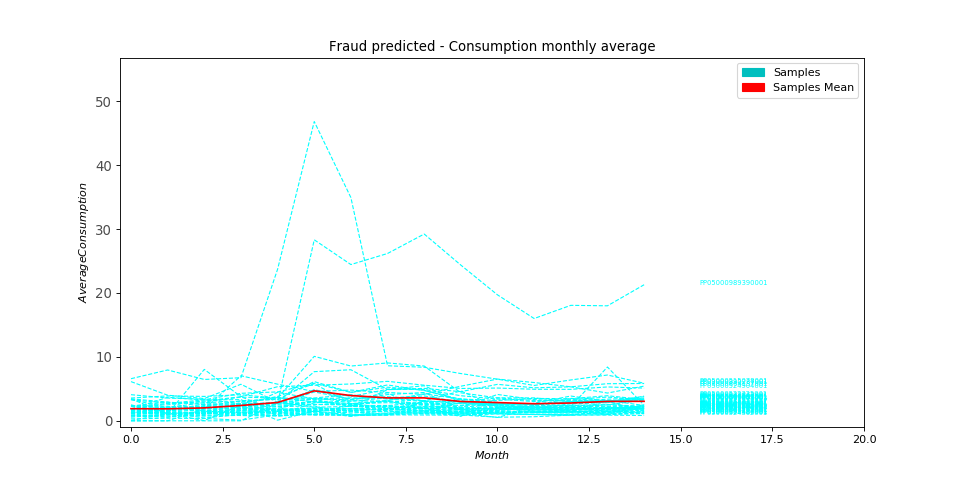

In [122]:
# Draw Fraud Predicted
import matplotlib.patches as mpatches

fraud_predicted_cl  = 'cyan'
normal_predicted_cl = 'black'

plt.figure(figsize = (12, 6), dpi = 80)

max_y = 0
sum_Y1 = np.zeros(15)
for i, y in enumerate(mdd_fraud_predicted):
    X = list(range(15))
    ind1 = fraud_df.loc[fraud_df['MA_DIEMDO'] == y].index.tolist()
    Y1 = list(fraud_df.iloc[ind1[0], :])[1:-1]
    max_y = max(max_y, max(Y1))
    sum_Y1 += np.array(Y1)
    plt.plot(X, Y1, color = fraud_predicted_cl, linestyle='dashed', linewidth = 1)
    plt.text(fraud_df.shape[1] - 1.5, Y1[-1], y , fontsize = 6, color = fraud_predicted_cl)
Y1_mean = sum_Y1/len(mdd_fraud_predicted)

plt.plot(X, Y1_mean, color = 'r')

plt.gca().set(xlim = (-0.3, 20), ylim = (-1, max_y + 10), ylabel = '$Average Consumption$', xlabel = '$Month$')
plt.yticks(fontsize = 12, alpha = 0.7)

patch_1 = mpatches.Patch(color='c', label='Samples')
patch_2 = mpatches.Patch(color='r', label='Samples Mean')

plt.legend(handles=[patch_1, patch_2])
plt.title("Fraud predicted - Consumption monthly average")
plt.show()